In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from pyNBS import pyNBS_plotting as plot
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

#### All clustering results used in this notebook were generated using the command line script of pyNBS

In [3]:
wd = './Supplementary_Notebook_Results/Benchmark_Results/'
clin_data_fn = './Supplementary_Notebook_Data/BLCA.clin.merged.surv.txt'

# Stochasticity of pyNBS
Here, we study the stochasticity of pyNBS. We perform the NBS algorithm with the pyNBS package using the same settings 10 times in a row with n=100 iterations of NBS for consensus clustering. All other settings for pyNBS are "default" with the only exception being k=4. We have observed previously that increasing n will narrow the variance of the pairwise [adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) shown below. 

In [4]:
# Get cluster assignments for each run of pyNBS
default_cluster_assigns = []
for fn in os.listdir(wd):
    if 'default' in fn and 'cluster_assignments' in fn:
        df = pd.read_csv(wd+fn,header=None, index_col=0)
        df.columns = [int(fn.split('_')[2])]
        default_cluster_assigns.append(df)
concat = pd.concat(default_cluster_assigns, axis=1)
concat = concat[sorted(concat.columns)]

In [5]:
# Calculate pairwise adjusted rand index between each clustering of BLCA data
ari_df = pd.DataFrame(np.zeros((10,10)),index=range(1,11), columns=range(1,11))
for i in range(1, 11):
    for j in range(1, 11):
        ari_df.loc[i][j] = adjusted_rand_score(concat.loc[:, i], concat.loc[:, j])
ari_vect = np.array(ari_df)[np.triu_indices(10, 1)]

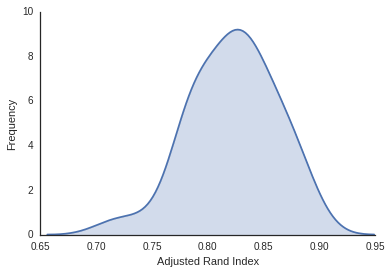

In [6]:
# Plot distribution of pairwise adjusted rand index
sns.kdeplot(ari_vect, shade=True)
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Frequency')
sns.despine()

Due to this stochasticity of the NBS algorithm, there may also be some variation in the final resulting log-rank statistic p-value.

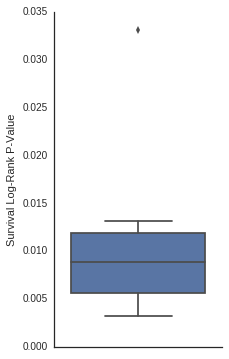

In [13]:
# Plot range of log-rank p-values for cluster assignments
default_p_vect = []
for fn in os.listdir(wd):
    if 'default' in fn and 'cluster_assignments' in fn:
        df = pd.read_csv(wd+fn,header=None, index_col=0, squeeze=True)
        p = plot.cluster_KMplot(df, clin_data_fn, delimiter=',', lr_test=True, verbose=False)
        default_p_vect.append(p)
        plt.close()
        
plt.figure(figsize=(3,6))
sns.boxplot(y=default_p_vect)
plt.ylabel('Survival Log-Rank P-Value')
sns.despine()

# Effects of $\alpha$ and k on final survival separation
Here, we examine the effect of changing k and $\alpha$ on the resulting survival log-rank p-value.

In [40]:
# Compile all survival log-rank p-values into pandas DataFrame
p_df = pd.DataFrame(index=range(2,8), columns=np.arange(0.1, 1.0, 0.1))
for k in range(2,8):
    for a in np.arange(0.1, 1.0, 0.1):
        fn = 'BLCA_k'+repr(k)+'_a'+str(a)+'_cluster_assignments.csv'
        assignment = pd.read_csv(wd+fn, header=None, index_col=0,squeeze=True)
        p = plot.cluster_KMplot(assignment, clin_data_fn, delimiter=',', lr_test=True, verbose=False)
        p_df.loc[k][a] = -np.log10(p)
        plt.close()

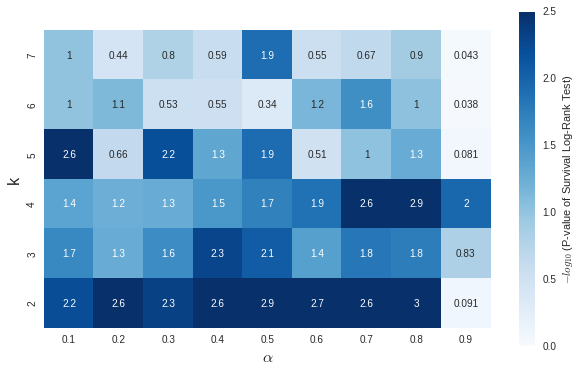

In [41]:
# Survival log-rank p-value heatmap for swept values of k and alpha
fig, ax = plt.subplots(figsize=(10,6))  
sns.heatmap(p_df, vmin=0, vmax=2.5, annot=True, square=True, ax=ax, cmap='Blues',
            cbar_kws={'label': r'$-log_{10}$ (P-value of Survival Log-Rank Test)'})
ax.invert_yaxis()
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel('k', fontsize=16)

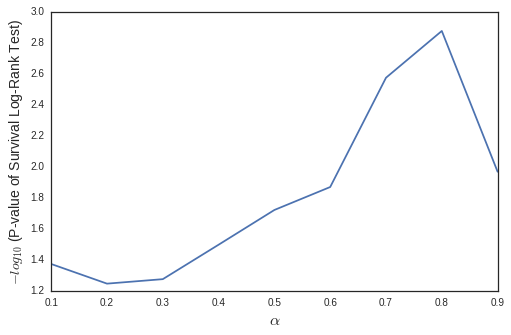

In [52]:
# The log-rank p-value when holding k constant and varying alpha
plt.figure(figsize=(8,5))

k=4
plt.plot(np.arange(0.1, 1.0, 0.1), p_df.loc[k], label='k='+str(k))
plt.xlim((0.1,0.9))
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$-log_{10}$ (P-value of Survival Log-Rank Test)', fontsize=14)

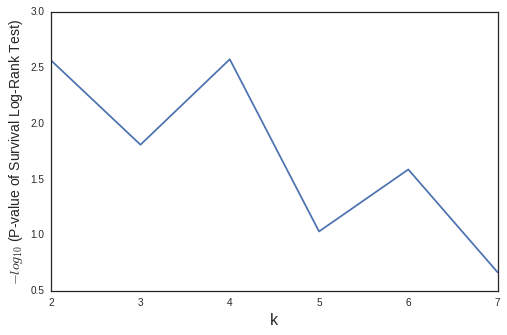

In [55]:
# The log-rank p-value when holding alpha constant and varying k
plt.figure(figsize=(8,5))

alpha=p_df.columns[6]
plt.plot(range(2,8), p_df[alpha])
plt.xlabel('k', fontsize=16)
plt.ylabel(r'$-log_{10}$ (P-value of Survival Log-Rank Test)', fontsize=14)